In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib notebook

In [4]:
# simulation time
sim_time = 200
time_step = 1

In [5]:
# Parametri che utilizzeremo sia per la funzione update che per la matrice P_out
D=1.4
T=0.6
D_out = D/20

In [6]:
# giu' su sinistra destra
colummella = [8,8,12,12]
# if in future we want to add lateral pin we already have everything set
epidermal_l, epidermal_r = [0,8,0,0], [0,8,0,0]
# if we want to add the last 5 cells to be longer this needs fix (grieneisen 2007 fig 1)
border_l, border_r = [8,0,0,12], [8,0,12,0]
vascular = [8,0,0,0]

P_out = np.zeros((22,12,4))

# 22 rows, 12 columns. The first is the upmost cell in the tip

# cinta esterna della radice (muraria)
P_out[0,:,:]=[0,0,0,0]
# this cells can only pass auxin to vascular and border
P_out[-1,:,:]=[8,0,0,0]
P_out[:,0,:]=[0,0,0,0]
P_out[:,-1,:]=[0,0,0,0]

# in futuro aggiungeremo un flusso di auxina dallo shoot

# defining colummellas
P_out[1:4,1:11] = colummella

# defining epidermal
P_out[4:21,1:3] = epidermal_l
P_out[4:21,9:11] = epidermal_r

# defining border
P_out[4:21,3] = border_l
P_out[4:21,8] = border_r

# defining vascular
P_out[4:21,4:8] = vascular

# defining QC in position [4,4:8] same PIN settings as vascular

P_out = P_out

In [14]:
def update_2D_old(cells, source=(4,4), source_val=10, D=D, T=T, P_out=P_out, decay=0.000005):
    """
    updates vector of cells following equation (1)

    
    cells : numpy array, set of cells to simulate
    source : int, index of QC cell
    source_val : float, amount of auxin produced at every step by the QC cell
    D : float, diffusion rate of auxin
    T : float, PIN1-mediated transport rate
    P_out : numpy matrix (lenght,width,4), amount of PIN1 that a cell outtakes to every neighbour (down, up, left, right)
    """
    # define neighbours
    v = np.array([[1,0], [-1,0], [0,-1], [0,1]])
    updated_cells = cells
    cells_flux = np.zeros((2,len(cells),12))
    for i, value in enumerate(cells[1:21], 1):
        step = np.zeros(cells.shape[1])
        step_direction_flux = np.zeros((2,cells.shape[1]))
        for j in range(1,len(cells[i])-1):
            neighbours = [cells[k]/96 for k in tuple(map(tuple, v + [i,j]))]
            
            auxin_square = value[j]/96
            
            D_out = D*(1/20)

            
            apoplast_down =  [neighbours[0]*8*D_out if P_out[i-1,j,1]==0 else T*P_out[i-1,j,1]*neighbours[0]*8][0]
            
            apoplast_up =  [neighbours[1]*8*D_out if P_out[i+1,j,0]==0 else T*P_out[i+1,j,0]*neighbours[1]*8][0]
            
            apoplast_left = [neighbours[2]*12*D_out if  P_out[i, j-1, 3]==0 else T*P_out[i, j-1, 3]*neighbours[2]*12][0]
            
            apoplast_right = [neighbours[3]*12*D_out if P_out[i, j+1, 2]==0 else T*P_out[i, j+1, 2]*neighbours[3]*12][0]
            
            diffusion_in_down= D*apoplast_down
            
            diffusion_in_up= D*apoplast_up
            
            diffusion_in_left= D*apoplast_left
            
            diffusion_in_right= D*apoplast_right
            
            diffusion_in_total = diffusion_in_down + diffusion_in_left + diffusion_in_right + diffusion_in_up
            
            
            # diffusion_out = -(1/20)*sum([1/(i) if i != 0 else 0 for i in neighbours])*D*value[j]

            aux_decay = -decay*value[j]
            
            transport_out_down = -T*P_out[i,j,0]*auxin_square*8
            transport_out_up =  -T*P_out[i,j,1]*auxin_square*8
            transport_out_left =  -T*P_out[i,j,2]*auxin_square*12
            transport_out_right = -T*P_out[i,j,3]*auxin_square*12
            
            ### diffusion out is considered only if PINs are not present
            
            diffusion_out_down = [auxin_square*8*(-D_out) if P_out[i,j,0] == 0 else 0][0]
            diffusion_out_up = [auxin_square*8*(-D_out) if P_out[i,j,1] == 0 else 0][0]
            diffusion_out_left = [auxin_square*12*(-D_out) if P_out[i,j,2] == 0 else 0][0]
            diffusion_out_right = [auxin_square*12*(-D_out) if P_out[i,j,3] == 0 else 0][0]
            
            # diffusion_out_down = auxin_square*8*(-D_out)
            # diffusion_out_up = auxin_square*8*(-D_out)
            # diffusion_out_left = auxin_square*12*(-D_out)
            # diffusion_out_right = auxin_square*12*(-D_out)
        
            
            # divide the output of the transport depending on the
            
            # these are the cases in which the cell is at an extremity: 
            # we don't have diffusion outside of the root itself!!
            
            if i == 1:
                diffusion_out_down, transport_out_down = 0,0
                
            if j == 1:
                diffusion_out_left, transport_out_left = 0,0
                
            if j == 10:
                diffusion_out_right, transport_out_right = 0,0
            
            diffusion_out_total = diffusion_out_down + diffusion_out_left + diffusion_out_right + diffusion_out_up 
            
            transport_out_total = transport_out_down + transport_out_left + transport_out_right + transport_out_up
            #transport_out_total = 0
            
            x_coord = (abs(transport_out_left)-abs(transport_out_right))
            y_coord = (abs(transport_out_up)-abs(transport_out_down))
            
            # last piece is the basal auxin production of each cell (a.u./(micrometers^2*sec))
            step[j] = value[j] + (transport_out_total + diffusion_out_total + diffusion_in_total + aux_decay + 8*12*0.0005*4)*0.5
            
            step_direction_flux[:,j] = (x_coord, y_coord)

            if step[j] <= 0:
                step[j] = 8*12*0.0005*4

        updated_cells[i,:] = [0] + step + [0]
        cells_flux[:,i,:] = [0] + step_direction_flux + [0]
#     updated_cells[source[0], source[1]:source[1]+4] += source_val*8*12
    return updated_cells,cells_flux

In [41]:
def update_2D(cells, dt, source=(0,0), source_val=10, D=D, T=T, P_out=P_out, decay=0.000005, upper_bound=5000):
    """
    updates vector of cells following equation (1)

    
    cells : numpy array, set of cells to simulate
    source : int, index of QC cell
    source_val : float, amount of auxin produced at every step by the QC cell
    D : float, diffusion rate of auxin
    T : float, PIN1-mediated transport rate
    P_out : numpy matrix (lenght,width,4), amount of PIN1 that a cell outtakes to every neighbour (down, up, left, right)
    """
    # define neighbours
    v = np.array([[1,0], [-1,0], [0,-1], [0,1]])
    updated_cells = cells
    cells_flux = np.zeros((2,len(cells),12))
    
    initial_concentrations = sum(sum(cells))
    qc = 0
    step_tot=0
    
    for i, value in enumerate(cells[1:21], 1):
        step = np.zeros(cells.shape[1])
        step_direction_flux = np.zeros((2,cells.shape[1]))
        for j in range(1,len(cells[i])-1):
            neighbours = [cells[k]/96 for k in tuple(map(tuple, v + [i,j]))]
            
            auxin_square = value[j]/96
            #aux_decay = -decay*value[j]            
            D_out = D*(1/20)
            
            #apoplast
            apoplast_down_neighbour =  [neighbours[0]*8*D_out if P_out[i-1,j,1]==0 else T*P_out[i-1,j,1]*neighbours[0]*8][0]
            apoplast_down_me = [auxin_square*8*D_out if P_out[i,j,0]==0 else T*P_out[i,j,0]*auxin_square*8][0]
            apoplast_down = apoplast_down_neighbour + apoplast_down_me
    
            apoplast_up_neighbour =  [neighbours[1]*8*D_out if P_out[i+1,j,0]==0 else T*P_out[i+1,j,0]*neighbours[1]*8][0]
            apoplast_up_me = [auxin_square*8*D_out if P_out[i,j,1]==0 else T*P_out[i,j,1]*auxin_square*8][0]
            apoplast_up = apoplast_up_neighbour + apoplast_up_me
    
            apoplast_left_neighbour = [neighbours[2]*12*D_out if  P_out[i, j-1, 3]==0 else T*P_out[i, j-1, 3]*neighbours[2]*12][0]
            apoplast_left_me = [auxin_square*8*D_out if P_out[i,j,2]==0 else T*P_out[i,j,2]*auxin_square*12][0]
            apoplast_left = apoplast_left_neighbour + apoplast_left_me
    
            apoplast_right_neighbour = [neighbours[3]*12*D_out if P_out[i, j+1, 2]==0 else T*P_out[i, j+1, 2]*neighbours[3]*12][0]
            apoplast_right_me = [auxin_square*12*D_out if P_out[i,j,3]==0 else T*P_out[i,j,3]*auxin_square*12][0]
            apoplast_right = apoplast_right_neighbour + apoplast_right_me
            
            # diffusion in
            diffusion_in_down= D*apoplast_down
            diffusion_in_up= D*apoplast_up
            diffusion_in_left= D*apoplast_left
            diffusion_in_right= D*apoplast_right
            diffusion_in_total = diffusion_in_down + diffusion_in_left + diffusion_in_right + diffusion_in_up
            
            # transport out: don't give to neighbou if he exceeds the upper bound
            transport_out_down = -T*P_out[i,j,0]*auxin_square*8
            transport_out_up =  -T*P_out[i,j,1]*auxin_square*8
            transport_out_left =  -T*P_out[i,j,2]*auxin_square*12
            transport_out_right = -T*P_out[i,j,3]*auxin_square*12
            transport_out_total = transport_out_down + transport_out_left + transport_out_right + transport_out_up
            
            # diffusion_out = -(1/20)*sum([1/(i) if i != 0 else 0 for i in neighbours])*D*value[j]
            diffusion_out_down = [auxin_square*8*(-D_out) if P_out[i,j,0] == 0 else 0][0]
            diffusion_out_up = [auxin_square*8*(-D_out) if P_out[i,j,1] == 0 else 0][0]
            diffusion_out_left = [auxin_square*12*(-D_out) if P_out[i,j,2] == 0 else 0][0]
            diffusion_out_right = [auxin_square*12*(-D_out) if P_out[i,j,3] == 0 else 0][0]
                
                
            # these are the cases in which the cell is at an extremity: we don't have diffusion outside of the root itself
            if i == 1:
                diffusion_out_down, transport_out_down = 0,0
            if j==1:
                diffusion_out_left, transport_out_left = 0,0
            if j==10:
                diffision_out_right, diffusion_out_right = 0,0
            
            diffusion_out_total = diffusion_out_down + diffusion_out_left + diffusion_out_right + diffusion_out_up 
            
            x_coord = (abs(transport_out_left)-abs(transport_out_right))
            y_coord = (abs(transport_out_up)-abs(transport_out_down))
            step_direction_flux[:,j] = (x_coord, y_coord)
              
            
            # last piece is the basal auxin production of each cell (a.u./(micrometers^2*sec))
            step[j] = transport_out_total + diffusion_out_total + diffusion_in_total
            if step[j] <= 0:
                step[j] = 8*12*0.0005*4
            step_tot += step[j]
            
            step[j] = value[j] + step[j]     
                
        updated_cells[i,:] = [0] + step + [0]
        cells_flux[:,i,:] = [0] + step_direction_flux + [0]
    
    
#     updated_cells[source[0], source[1]:source[1]+4] += source_val*8*12*dt
    
    #print(initial_concentrations, sum(sum(updated_cells)), step_tot+source_val*8*12*4)
    return dt*updated_cells,dt*cells_flux, qc

<IPython.core.display.Javascript object>


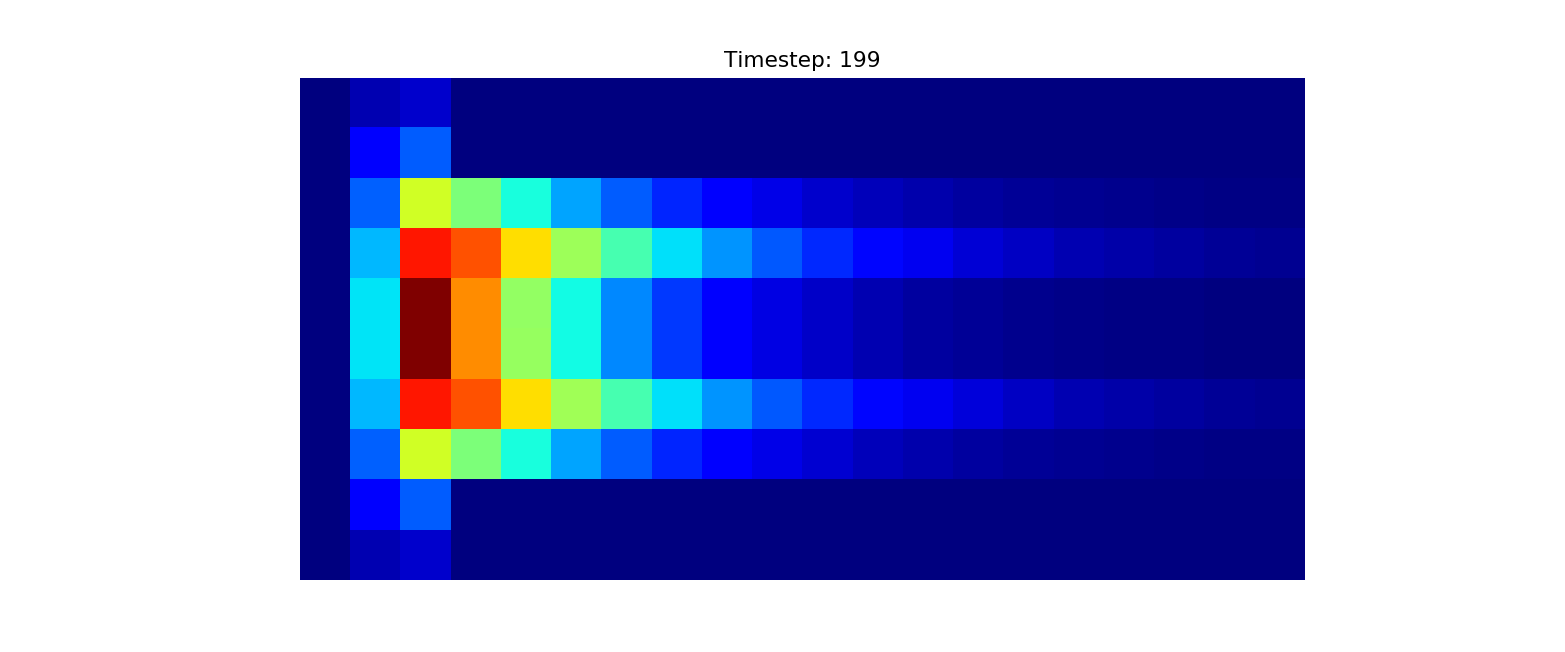

/home/simone/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/home/simone/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/home/simone/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/home/simone/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/home/simone/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/quiver.py:678: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/home/simone/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
%matplotlib notebook
# number of cells within one single tissue
cells_a = np.ones((22,12))*20
cells_a[0,:]=0
cells_a[-1,:]=70
cells_a[:,0]=0
cells_a[:,-1]=0
# QC cell starts with an initial amount of auxin
#cells_a[3][1] = 10
cells_a[4,4:8] = 100
fig= plt.figure(figsize=(12,5)) #common canvas for any figure
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(cells_a[1:-1,1:-1].T, cmap="jet")
cells_out = cells_a

times = np.arange(0, sim_time, time_step)   

for t in times:
    cells_out, cells_fluxes, qc = update_2D(cells_out, dt=0.00001)
    #print(cells_fluxes)
    plt.imshow(cells_out[1:-1,1:-1].T, cmap="jet")
    
# ### normalized arrows

    U = cells_fluxes[1,1:-1,1:-1].T
    V = cells_fluxes[0,1:-1,1:-1].T
    U_norm = U / np.sqrt(U**2 + V**2)
    V_norm = V / np.sqrt(U**2 + V**2)
    
    plt.quiver(U_norm, V_norm, pivot='mid')

    plt.title(f"Timestep: {str(t)}")
    plt.axis('off')
    fig.canvas.draw()
    fig.canvas.flush_events()
    if t != times[-1]:
        plt.clf() ##to avoid the clearance of the plot


D and T are not working as we can't find a proper way to define them and find an equivalent in the literature. 

TODO:
create a flux model (see grieneisen 2007 Fig 2c) to see whether we can recover a reverse fountain loop (or where where doing it wrong!) 

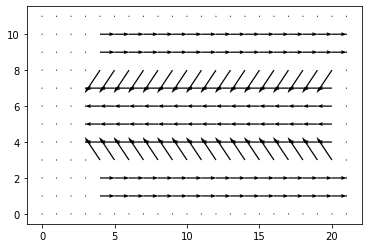

In [90]:
# (left-right),(up-down)
%matplotlib inline
P_flux = np.array([P_out[:,:,2]-P_out[:,:,3],P_out[:,:,1]-P_out[:,:,0]])

plt.quiver(P_flux[1,:,:].T,P_flux[0,:,:].T)
plt.show()

In [23]:
U.shape

(12, 22)

In [58]:
X = np.array([[1,2,3],
            [4,5,6],
            [6,7,8]])
# 
v = np.array([[1,0], [-1,0], [0,-1], [0,1]])

In [59]:
# up, down 
[X[k] for k in tuple(map(tuple, v + [1,1]))]

[7, 2, 4, 6]

In [57]:
v + [1,1]

array([[0, 1],
       [2, 1],
       [1, 0],
       [1, 2]])

## Apoplasto e follie

Consideriamo la concentrazione dell'auxina esclusivamente al contorno (ovvero l'auxina che nel timestep dato e' in grado di arrivare alla memebrana e passare oltre). 

Nel modello di grieneisen 2007 viene considerato un apoplasto in cui le cellule emettono auxina ad un certo rate e l'auxina presente nell'apoplasto viene conseguentemente assorbita con un altro rate (dipendente dalla quantita' di auxina nell'apoplasto e non direttamente dalla qta' di auxina emessa tramite PIN dalle cellule adiacenti).

Grieneisen considera uno spazio intermedio tra le cellule dove si accumula l'auxina che viene emessa tramite PIN (dalle cellule vicine) e assorbita in maniera passiva (dalla cellula correntemente analizzata). 

Assumiamo la quantita' di auxina presente nell'apoplasto costante e dipendenta da:

- auxina espulsa dalla cellula analizzata tramite PIN (o per diffusione basale) (1)
- auxina espulsa dalla cellula vicina alla cellula analizzata tramite PIN (o per diffusione basale) (2)
- auxina assorbita dalla cellula vicina (3)
- auxina assorbita dalla cellula analizzata (4)

(1) + (2) + (3) + (4) = 0

(4) = - (1) - (2) - (3)

In [ ]:
###Vecchio modello 


def update_2D(cells, source=(4,4), source_val=10, D=0.5, T=0.5, P_out=P_out, decay=0.000005):
    """
    updates vector of cells following equation (1)
    
    WORKS ONLY FOR 1D MODELS
    
    cells : numpy array, set of cells to simulate
    source : int, index of QC cell
    source_val : float, amount of auxin produced at every step by the QC cell
    D : float, diffusion rate of auxin
    T : float, PIN1-mediated transport rate
    P_out : numpy matrix (lenght,width,4), amount of PIN1 that a cell outtakes to every neighbour (down, up, left, right)
    """
    # define neighbours
    v = np.array([[1,0], [-1,0], [0,-1], [0,1]])
    updated_cells = cells
    cells_flux = np.zeros((2,len(cells),12))
    for i, value in enumerate(cells[1:21], 1):
        step = np.zeros(cells.shape[1])
        step_direction_flux = np.zeros((2,cells.shape[1]))
        for j in range(1,len(cells[i])-1):
            neighbours = [cells[k] for k in tuple(map(tuple, v + [i,j]))]
            
            diffusion_in = sum(neighbours)*(D/(value[j]+1))
            #diffusion_out = -(1/2.5)*sum([1/(i) if i != 0 else 0 for i in neighbours])*D*value[j]
            aux_decay = -decay*value[j]

            #transport_in = T*np.dot(P_out[i,j,:],neighbours)
            transport_out = -T*sum(P_out[i,j,:])*value[j]
            
            
            
            # divide the output of the transport depending on the direction
            transport_out_down = T*P_out[i,j,0]*value[j]
            transport_out_up =  T*P_out[i,j,1]*value[j]
            transport_out_left =  T*P_out[i,j,2]*value[j]
            transport_out_right = T*P_out[i,j,3]*value[j]
            
            x_coord = (transport_out_left-transport_out_right)
            y_coord = (transport_out_up-transport_out_down)
            
            # last piece is the basal auxin production of each cell (a.u./(micrometers^2*sec))
            step[j] = value[j] + transport_in + transport_out + diffusion_in + diffusion_out + aux_decay + 16*24*0.0005
            step_direction_flux[:,j] = (x_coord, y_coord)

            if step[j] <= 0:
                step[j] = 16*24*0.0005

        updated_cells[i,:] = [0] + step + [0]
        cells_flux[:,i,:] = [0] + step_direction_flux + [0]
    updated_cells[source[0], source[1]:source[1]+4] += source_val*16*24
    return updated_cells,cells_flux



<IPython.core.display.Javascript object>


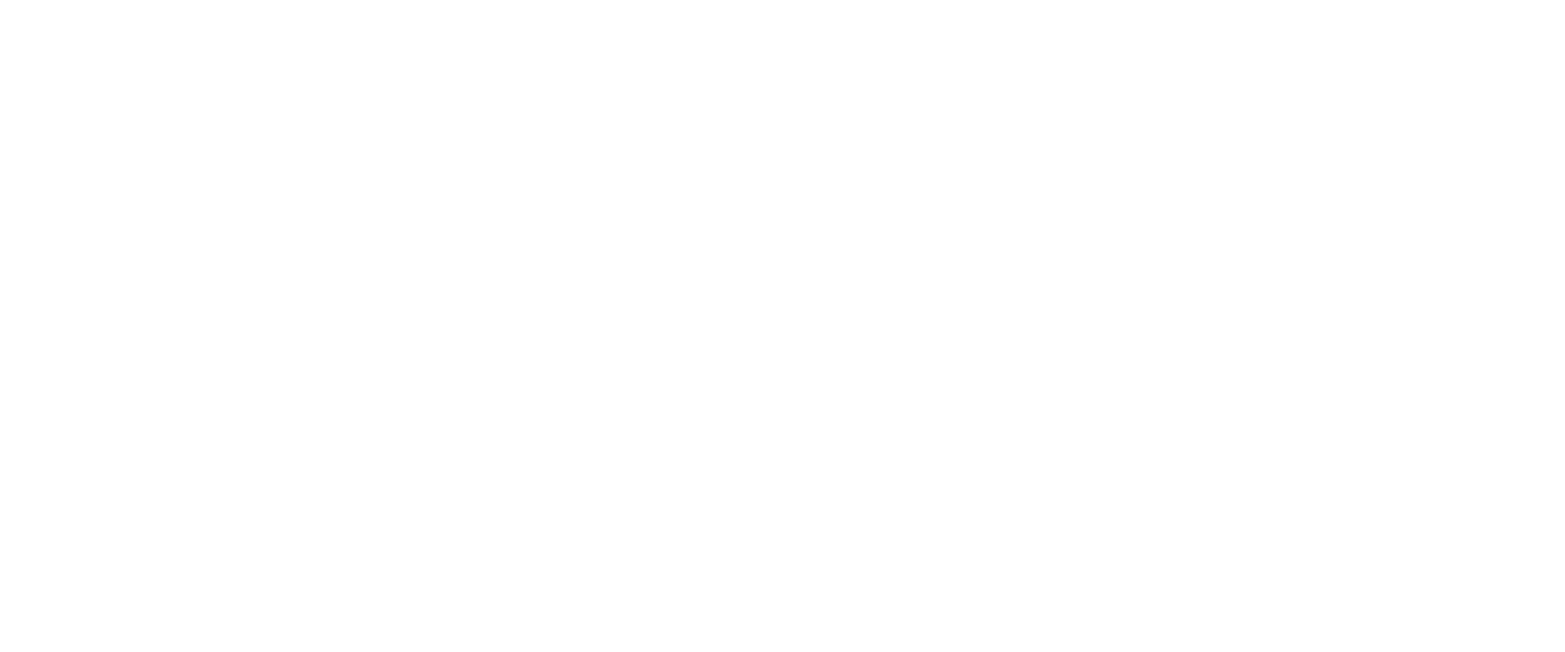

KeyboardInterrupt: 

In [37]:
%matplotlib notebook
# number of cells within one single tissue
cells_a = np.ones((22,12))*20
cells_a[0,:]=0
cells_a[-1,:]=70
cells_a[:,0]=0
cells_a[:,-1]=0
# QC cell starts with an initial amount of auxin
#cells_a[3][1] = 10
cells_a[4,4:8] = 100
fig= plt.figure(figsize=(12,5)) #common canvas for any figure
plt.ion()
plt.title('Time: Beginning')
plt.axis('off')
plt.imshow(cells_a.T, cmap="jet")
cells_out = cells_a

times = np.arange(0, sim_time, time_step)

for t in times:
    cells_out, cells_fluxes = update_2D(cells_out, T=0, D=0.2)
    #print(cells_fluxes)
    plt.imshow(cells_out.T, cmap="jet")
    plt.quiver(cells_fluxes[1,:,:].T,cells_fluxes[0,:,:].T)
    plt.title(f"Timestep: {str(t)}")
    plt.axis('off')
    fig.canvas.draw()
    fig.canvas.flush_events()
    if t != times[-1]:
        plt.clf() ##to avoid the clearance of the plot
